(markdown是用jupypter notebook生成)
<hr>
mxnet为的提高IO效率, 不会直接读取图片文件, 而是先将图片列表和标签转换为RecordIO格式的二进制文件, 训练时就可以顺序读取数据, 大大提高了IO速率.
# 如何将图片列表与标签转换为RecordIO?
 mxnet直接提供了mnist与cifar数据集的recordIO格式, 但为了熟悉这个过程, 我决定自己手动来一遍: 将mnist数据的原始二进制格式转换为recordIO格式.
## 如何将mnist ubyte文件转换成image 文件与lst?
从[Yan Lecun](http://yann.lecun.com/exdb/mnist/index.html)网站上下载下来的原始数据由以下四部分组成

In [1]:
!ls ../dataset/mnist

t10k-images-idx3-ubyte	train-images-idx3-ubyte
t10k-labels-idx1-ubyte	train-labels-idx1-ubyte


### 怎样读取训练数据?

train images和labels两个文件分别训练数据的图片与标签, 数量为50k.  t10k images 和labels则是测试数据, 10k.
先写脚本读取训练数据, 生成im2rec需要的图片文件与lst文件. train-images-idx3-ubyte文件的数据格式为:
```
# The labels values are 0 to 9.
# TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
# [offset] [type]          [value]          [description]
# 0000     32 bit integer  0x00000803(2051) magic number
# 0004     32 bit integer  60000            number of images
# 0008     32 bit integer  28               number of rows
# 0012     32 bit integer  28               number of columns
# 0016     unsigned byte   ??               pixel
# 0017     unsigned byte   ??               pixel
# ........
# xxxx     unsigned byte   ??               pixel
```

In [2]:
import sys;
file_path = '../dataset/mnist/';
train_images_ubyte = file_path + 'train-images-idx3-ubyte';
train_labels_ubyte = file_path + 'train-labels-idx1-ubyte';
test_images_ubyte = file_path + 'test-images-idx3-ubyte';
test_labels_ubyte = file_path + 'test-labels-idx1-ubyte';

train_images = [];
train_labels = [];
def readInt(f, n = 4):
    """从mnist二进制文件中读取整数"""
    return int(f.read(n).encode('hex'), 16);
def readImage(f):
    """从mnist二进制文件中读取图片"""
    n = 28*28;
    img = [0]*n;
    for i in xrange(n):#这样一个一个字节地读取会很慢
        img[i] = readInt(f, 1);
    return img;

# 读取图片
with open(train_images_ubyte, 'r') as f:
    magic = readInt(f);
    num_img = readInt(f);
    num_rows = readInt(f);
    num_cols = readInt(f);

    for i in range(num_img):
        train_images.append(readImage(f));

train-labels-idx1-ubyte的数据格式如下:
```
#  TRAINING SET LABEL FILE (train-labels-idx1-ubyte):
# [offset] [type]          [value]          [description]
# 0000     32 bit integer  0x00000801(2049) magic number (MSB first)
# 0004     32 bit integer  60000            number of items
# 0008     unsigned byte   ??               label
# 0009     unsigned byte   ??               label
# ........
# xxxx     unsigned byte   ??               label
# 
```

In [3]:
def readLabel(f):
    """从mnist二进制文件中读取label"""
    return readInt(f, 1);

# 读取标签
with open(train_labels_ubyte, 'r') as f:
    magic = readInt(f);
    num_items = readInt(f);
    
    for i in xrange(num_items):
        train_labels.append(readLabel(f));

### 可视化一下读取出来的数据
没什么实质性的功能, 就为了看看读出来的数据是怎样的. 

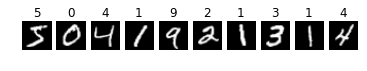

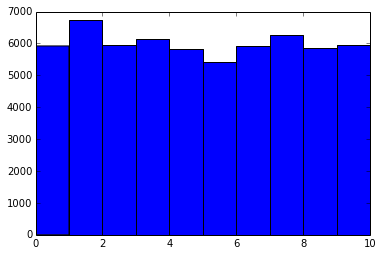

In [4]:
import matplotlib.pyplot as plt;
import numpy as np;
%matplotlib inline

def list2img(arr):
    return np.reshape(arr, (28, 28));
# 显示几张图片及其对应对手写数字；
num = 10
for i in range(num):
    img = list2img(train_images[i]);    
    plt.subplot(1,num,i+1);
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(train_labels[i])

# 画一张条形图看看数字的分布
plt.figure()
plt.hist(train_labels, range(11));


可以看出, 每个数字的分布还是挺均匀的.

### 导出图片, 并生成lst文件

In [5]:
#导出图片  
import cv2
import os
file_dir = '/home/dengdan/dataset/mnist/raw/train/images/';
if not os.path.exists(file_dir) or not os.path.isdir(file_dir):
    os.makedirs(file_dir);
file_name = 'mnist_train_{0}.jpg';
n = len(train_images)
for i in xrange(n):
    img = list2img(train_images[i]);    
    #cv2.imwrite(file_dir + file_name.format(i), img)

lst 文件用于将图片文件与它的label对应起来. 每一行为一条记录, 格式为:
```
integer_image_index \t label_index \t path_to_image
```
```
895099  464     n04467665_17283.JPEG
10025081        412     ILSVRC2010_val_00025082.JPEG
74181   789     n01915811_2739.JPEG
10035553        859     ILSVRC2010_val_00035554.JPEG
10048727        929     ILSVRC2010_val_00048728.JPEG
94028   924     n01980166_4956.JPEG
1080682 650     n11807979_571.JPEG
972457  633     n07723039_1627.JPEG
7534    11      n01630670_4486.JPEG
1191261 249     n12407079_5106.JPEG
```

In [6]:
# 生成lst 文件
def rec(idx, label):
    """生成第idx张图片的记录"""
    name = file_name.format(idx);
    return '{0} \t {1} \t {2}'.format(idx, label, name)

lst_path = '/home/dengdan/dataset/mnist/mxnet/'
if not os.path.exists(lst_path) or not os.path.isdir(lst_path):
    os.makedirs(lst_path);
lst = lst_path + 'train.lst';
with open(lst, 'w') as f:
    for i in xrange(len(train_labels)):
        record = rec(i, train_labels[i]);
        f.write(record + '\n');

现在, 图片也有了, lst文件也有了, 可以利用im2rec工具生成recordio文件了

In [7]:
! ~/github/mxnet/bin/im2rec ~/dataset/mnist/mxnet/train.lst  ~/dataset/mnist/raw/train/images/   ~/dataset/mnist/mxnet/train.bin

[16:28:31] tools/im2rec.cc:96: Keep origin image size
[16:28:31] tools/im2rec.cc:107: Encoding is .jpg
[16:28:31] tools/im2rec.cc:153: Write to output: /home/dengdan/dataset/mnist/mxnet/train.bin
[16:28:31] tools/im2rec.cc:155: Output: /home/dengdan/dataset/mnist/mxnet/train.bin
[16:28:31] tools/im2rec.cc:168: JPEG encoding quality: 80
[16:28:31] tools/im2rec.cc:251: 1000 images processed, 0.0781758 sec elapsed
[16:28:31] tools/im2rec.cc:251: 2000 images processed, 0.151105 sec elapsed
[16:28:32] tools/im2rec.cc:251: 3000 images processed, 0.224051 sec elapsed
[16:28:32] tools/im2rec.cc:251: 4000 images processed, 0.296463 sec elapsed
[16:28:32] tools/im2rec.cc:251: 5000 images processed, 0.370086 sec elapsed
[16:28:32] tools/im2rec.cc:251: 6000 images processed, 0.444228 sec elapsed
[16:28:32] tools/im2rec.cc:251: 7000 images processed, 0.518702 sec elapsed
[16:28:32] tools/im2rec.cc:251: 8000 images processed, 0.59227 sec elapsed
[16:28:32] tools/im2rec.cc:251: 9000 images processed,